# Hands sync

This is the fourth part of my project, in this part we will try to make a classifier for hand movement, to see if it was alone, syncronized or not

[conclusion](#conclusion)

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
import random
%matplotlib inline
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB      
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#function to add tags to the rows. 0 will be alone, 1 is spontanious and 2 is syncronized
def add_tag(dataframe, path):
    if "Spontan" in path:
        tags = np.ones(dataframe.shape[0],dtype=int)
        dataframe['Label'] = tags
    elif "Alone" in path:
        tags = np.zeros(dataframe.shape[0],dtype=int)
        dataframe['Label'] = tags
    else:
        tags = np.full(dataframe.shape[0], 2,dtype = int)
        dataframe['Label'] = tags


In [4]:
#function to merge all rows in a file that have the same second but diffrent hands
def merge_right_left(path,RightHand):
    df = pd.read_csv(path)
    df = df.iloc[700:] # removing the first 7 second from the file
    if "Alone" in path :
        try:
            df = df.loc[df[' Hand Type'] == "left"]
        finally:
            for column in RightHand.columns: #lets rename the columns so we know which is right nad which is left
                RightHand = RightHand.rename(columns = {column: column + "_R"})
            for column in df.columns:
                df = df.rename(columns = {column: column + "_L"})
            to_merge = [df,RightHand]
            merged = pd.concat(to_merge,axis = 1)
            add_tag(merged, path)
    else:
        right = df.loc[df[" Hand Type"] == "right"]
        left = df.loc[df[" Hand Type"] == "left"]
        for column in right.columns: #lets rename the columns so we know which is right nad which is left
            right = right.rename(columns = {column: column + "_R"})
        for column in left.columns:
            left = left.rename(columns = {column: column + "_L"})
        merged = right.merge(left, left_on="Time_R", right_on = "Time_L")
        add_tag(merged, path)
    return merged

First, lets get one of the files and see what it looks like

In [5]:
df = pd.read_csv("D:\\ML_SEM2\\extraFiles\\Training\\All in one\\Evyatar636771052727603804Spontan.csv")

In [6]:
df.head(20)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,335.9984,128556,right,2,128.63570,224.0294,-12.29588,-18.26243,-140.54450,-117.577900,...,-1.588251,177.5125,173.5658,-14.569630,276.8753,-33.68264,91.61740,0.000000,1.250576,0.0
1,335.9984,128556,left,2,-93.24845,143.9423,-37.81597,-109.09820,240.38980,-67.629590,...,0.873458,-147.0455,109.9380,-5.326688,-329.8577,-34.41571,93.88171,0.000000,0.014736,0.0
2,336.0150,128558,right,2,129.15550,221.9923,-15.00181,47.36464,-64.25022,-168.858500,...,-1.528183,177.7894,171.1952,-14.677850,276.0645,-33.15913,97.88171,0.000000,1.069930,0.0
3,336.0150,128558,left,2,-94.86554,148.5542,-39.00158,-80.99012,278.60220,-66.793560,...,0.879703,-148.2022,113.0909,-7.375025,-326.9279,-39.97873,85.98000,0.000000,0.000000,0.0
4,336.0315,128560,right,2,129.87070,220.7944,-18.38681,35.05422,-84.74242,-205.720300,...,-1.461710,178.3730,169.9159,-15.246240,276.1767,-30.72506,104.13920,0.000000,0.916969,0.0
5,336.0315,128560,left,2,-95.16259,152.5339,-39.94570,-11.37293,232.80310,-53.320790,...,0.895820,-148.3343,115.9295,-9.437292,-322.0559,-44.42383,81.02193,0.000000,0.000000,0.0
6,336.0481,128562,right,2,131.07210,219.2134,-22.05511,36.51635,-153.35370,-212.825900,...,-1.380241,179.5035,168.4482,-15.568560,276.6018,-31.22840,105.96400,0.000000,0.798334,0.0
7,336.0481,128562,left,2,-95.37997,156.0973,-40.18840,-3.05615,203.81210,19.494730,...,0.918827,-148.3562,118.3093,-10.919770,-314.2976,-49.04110,81.41824,0.000000,0.000000,0.0
8,336.0651,128564,right,2,132.46290,216.8003,-25.45043,98.73232,-65.53646,-218.720100,...,-1.287442,179.5375,165.1393,-15.531890,271.5673,-37.88867,104.38140,0.000000,0.728858,0.0
9,336.0651,128564,left,2,-97.10074,161.7751,-40.36338,-98.92747,316.64520,-7.328697,...,0.946004,-149.2292,121.7602,-12.780660,-299.9106,-56.55378,85.03669,0.000000,0.000000,0.0


In [7]:
df.isnull().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [8]:
df.columns

Index(['Time', ' Frame ID', ' Hand Type', ' # hands', ' Position X',
       ' Position Y', ' Position Z', ' Velocity X', ' Velocity Y',
       ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength'],
      dtype='object')

now lets see how one of the aloen files looks like and how the HandRight looks right

In [9]:
HandRight = pd.read_csv("D:\\ML_SEM2\\extraFiles\\HandRight.csv")

In [10]:
HandRight.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [11]:
HandRight = HandRight.loc[HandRight[' Hand Type'] == "right"]

In [12]:
HandRight.isnull().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [13]:
alone_test = pd.read_csv("D:\\ML_SEM2\\extraFiles\\Training\\All in one\\Evyatar636771054555711409Alone.csv")

In [14]:
alone_test.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,518.8087,149620,left,1,-97.60160,164.1213,42.81255,104.2589,-491.6730,-55.42755,...,1.661706,-166.7207,164.8320,27.58547,-378.1662,65.89330,-69.90282,0.0,0.741855,0.0
1,518.8252,149622,left,1,-95.78062,157.6353,42.18084,148.9683,-351.7386,-36.32422,...,1.623222,-165.4907,155.6419,29.71037,-380.3233,52.92441,-55.71872,0.0,0.827916,0.0
2,518.8418,149623,left,1,-94.39360,154.6338,41.93171,161.6958,-349.9117,-29.04277,...,1.602898,-164.3658,151.5701,31.05059,-381.7444,48.55032,-47.27909,0.0,0.920401,0.0
3,518.8587,149625,left,1,-92.02553,150.6723,42.10119,117.3475,-187.1781,24.42598,...,1.567605,-162.2663,144.6214,33.94577,-383.4688,40.27151,-30.72728,0.0,1.034603,0.0
4,518.8749,149627,left,1,-89.31953,148.1826,42.67065,155.3344,-135.6337,35.87055,...,1.535920,-159.4586,138.6087,36.68195,-381.0906,29.07133,-17.01065,0.0,1.166705,0.0


To import the files, I moved all the files to one folder so it will be easier

In [15]:
path = "D:\\ML_SEM2\\extraFiles\\Training\\All in one"
paths = []
for file in os.listdir(path):
    paths.append(path + "\\"+file)

In [16]:
first_to_merge = merge_right_left(paths[0],HandRight)
i = 1
for i in range(len(paths)):
    to_merge = [first_to_merge,merge_right_left(paths[i],HandRight)]
    first_to_merge = pd.concat(to_merge,ignore_index = True)

In [17]:
first_to_merge

,Time_R,Frame ID_R,Hand Type_R,# hands_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
0,341.7967,129224.0,right,2.0,165.22510,216.0903,-19.45348,15.52354,-2.030462,-31.49404,...,-139.5122,148.6714,-0.907297,-302.5069,-40.675890,29.01158,0.0,0.0,0.0,1
1,341.8133,129226.0,right,2.0,165.59600,216.3511,-19.95448,28.74473,22.921360,-28.63050,...,-139.5220,148.0659,-1.579993,-299.5904,-43.172770,31.89713,0.0,0.0,0.0,1
2,341.8307,129228.0,right,2.0,166.11170,216.7622,-20.38730,29.43071,24.043140,-25.71594,...,-139.3322,146.9565,-2.184220,-296.7033,-45.545420,36.44461,0.0,0.0,0.0,1
3,341.8468,129230.0,right,2.0,166.66040,217.2612,-20.83806,28.51993,26.253250,-23.28648,...,-139.0374,145.6480,-2.581171,-294.6625,-47.203460,41.05309,0.0,0.0,0.0,1
4,341.8634,129232.0,right,2.0,166.99080,217.6637,-21.26701,19.56766,25.092050,-23.05861,...,-138.6565,144.6211,-2.772674,-291.4951,-49.536060,44.74752,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103476,856.1965,67304.0,right,2.0,97.75611,205.9629,30.04651,28.36298,77.443350,162.14280,...,-107.8500,127.8215,32.852500,-318.7630,20.751860,138.01250,0.0,0.0,0.0,2
103477,856.2291,67306.0,right,2.0,98.93275,208.3153,34.85991,44.38393,71.368570,187.54080,...,-108.0805,128.1729,33.403910,-314.6744,14.308990,139.99090,0.0,0.0,0.0,2
103478,856.2631,67309.0,right,2.0,101.91230,212.0264,42.53568,79.95810,113.410300,190.77140,...,-109.0018,129.5246,33.898560,-304.9600,-0.548136,142.01090,0.0,0.0,0.0,2
103479,856.2958,67311.0,right,2.0,103.84750,214.7484,47.07082,61.11773,95.135310,155.74530,...,-109.7250,130.7078,34.033600,-295.5957,-14.978170,140.02630,0.0,0.0,0.0,2


In [18]:
first_to_merge.isnull().any().sum()

44

Lets remove all the rows that have null values

In [19]:
final = first_to_merge.dropna()

In [20]:
final.isnull().any().sum()

0

In [21]:
final.isnull().sum()

Time_R               0
 Frame ID_R          0
 Hand Type_R         0
 # hands_R           0
 Position X_R        0
 Position Y_R        0
 Position Z_R        0
 Velocity X_R        0
 Velocity Y_R        0
 Velocity Z_R        0
 Pitch_R             0
 Roll_R              0
 Yaw_R               0
 Wrist Pos X_R       0
 Wrist Pos Y_R       0
 Wrist Pos Z_R       0
 Elbow pos X_R       0
 Elbow Pos Y_R       0
 Elbow Pos Z_R       0
 Grab Strenth_R      0
 Grab Angle_R        0
 Pinch Strength_R    0
Time_L               0
 Frame ID_L          0
 Hand Type_L         0
 # hands_L           0
 Position X_L        0
 Position Y_L        0
 Position Z_L        0
 Velocity X_L        0
 Velocity Y_L        0
 Velocity Z_L        0
 Pitch_L             0
 Roll_L              0
 Yaw_L               0
 Wrist Pos X_L       0
 Wrist Pos Y_L       0
 Wrist Pos Z_L       0
 Elbow pos X_L       0
 Elbow Pos Y_L       0
 Elbow Pos Z_L       0
 Grab Strenth_L      0
 Grab Angle_L        0
 Pinch Stre

In [22]:
final 

,Time_R,Frame ID_R,Hand Type_R,# hands_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
0,341.7967,129224.0,right,2.0,165.22510,216.0903,-19.45348,15.52354,-2.030462,-31.49404,...,-139.5122,148.6714,-0.907297,-302.5069,-40.675890,29.01158,0.0,0.0,0.0,1
1,341.8133,129226.0,right,2.0,165.59600,216.3511,-19.95448,28.74473,22.921360,-28.63050,...,-139.5220,148.0659,-1.579993,-299.5904,-43.172770,31.89713,0.0,0.0,0.0,1
2,341.8307,129228.0,right,2.0,166.11170,216.7622,-20.38730,29.43071,24.043140,-25.71594,...,-139.3322,146.9565,-2.184220,-296.7033,-45.545420,36.44461,0.0,0.0,0.0,1
3,341.8468,129230.0,right,2.0,166.66040,217.2612,-20.83806,28.51993,26.253250,-23.28648,...,-139.0374,145.6480,-2.581171,-294.6625,-47.203460,41.05309,0.0,0.0,0.0,1
4,341.8634,129232.0,right,2.0,166.99080,217.6637,-21.26701,19.56766,25.092050,-23.05861,...,-138.6565,144.6211,-2.772674,-291.4951,-49.536060,44.74752,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103476,856.1965,67304.0,right,2.0,97.75611,205.9629,30.04651,28.36298,77.443350,162.14280,...,-107.8500,127.8215,32.852500,-318.7630,20.751860,138.01250,0.0,0.0,0.0,2
103477,856.2291,67306.0,right,2.0,98.93275,208.3153,34.85991,44.38393,71.368570,187.54080,...,-108.0805,128.1729,33.403910,-314.6744,14.308990,139.99090,0.0,0.0,0.0,2
103478,856.2631,67309.0,right,2.0,101.91230,212.0264,42.53568,79.95810,113.410300,190.77140,...,-109.0018,129.5246,33.898560,-304.9600,-0.548136,142.01090,0.0,0.0,0.0,2
103479,856.2958,67311.0,right,2.0,103.84750,214.7484,47.07082,61.11773,95.135310,155.74530,...,-109.7250,130.7078,34.033600,-295.5957,-14.978170,140.02630,0.0,0.0,0.0,2


As we can see there arr no rows where they have the same hand type

In [23]:
check = final.loc[final[' Hand Type_R'] == final[' Hand Type_L']]
check

,Time_R,Frame ID_R,Hand Type_R,# hands_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label


Lets check that we included the alone case alright

In [24]:
alone = final.loc[final['Label'] == 0]
alone

,Time_R,Frame ID_R,Hand Type_R,# hands_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
13230,139.9508,16823.0,right,1.0,27.55041,232.7543,32.63120,322.7586,278.72130,125.8454,...,-128.6107,157.1767,11.709480,-372.7614,95.06994,-3.509623,0.000000,0.000000,0.000000,0
13231,139.9675,16825.0,right,1.0,33.19647,237.5320,34.52997,327.7466,268.37760,121.5597,...,-125.8682,163.2764,10.455360,-367.8976,93.74731,-6.454181,0.000000,0.000000,0.000000,0
13232,139.9841,16827.0,right,1.0,38.97433,240.9470,37.03607,326.4416,174.81330,133.4255,...,-123.6989,171.1135,9.399913,-362.2924,90.64447,-7.814807,0.000000,0.000000,0.000000,0
13233,140.0007,16829.0,right,1.0,44.82454,243.5725,39.49437,343.5013,165.16940,159.3833,...,-122.8946,179.3406,8.266642,-357.8594,88.99447,-9.833598,0.000000,0.000000,0.000000,0
13234,140.0173,16831.0,right,1.0,50.88591,245.9141,42.02524,331.1370,87.78233,134.3925,...,-121.2043,184.8807,6.797836,-353.5380,87.82373,-10.507740,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99048,165.0256,19714.0,right,1.0,-11.48835,156.5860,48.36269,-145.6763,483.15760,192.1477,...,-146.6314,148.2971,44.407660,-258.0887,-77.52971,112.970600,0.116068,1.901876,0.000000,0
99049,165.0425,19716.0,right,1.0,-13.89239,164.0521,51.71035,-149.5128,406.57340,211.2847,...,-146.1113,148.8045,45.689300,-253.6847,-80.13625,109.996700,0.134497,1.952747,0.000000,0
99050,165.0588,19718.0,right,1.0,-16.51222,170.2372,55.29509,-155.2818,363.51390,226.1397,...,-144.8174,148.4588,46.660750,-249.6531,-83.33176,105.004300,0.120680,1.984825,0.000000,0
99051,165.0759,19720.0,right,1.0,-18.65446,175.8734,59.29584,-121.0561,262.37540,216.8575,...,-143.8482,148.1024,46.728610,-248.2768,-84.26936,103.468300,0.097735,1.988376,0.000000,0


Next lets import the validation data and do the same procedure to prepare it 

In [25]:
path_vali = "D:\\ML_SEM2\\extraFiles\\Validation\\all_in_one_vali"
test_files =[]
for file in os.listdir(path_vali):
    test_files.append(path_vali + "\\"+file)

In [26]:
test_merged = merge_right_left(test_files[0],HandRight)
i = 1
for i in range(len(test_files)):
    to_merge = [test_merged,merge_right_left(test_files[i],HandRight)]
    test_merged = pd.concat(to_merge,ignore_index = True)

In [27]:
test_merged.isnull().any().sum()

44

In [28]:
test_final = test_merged.dropna()

In [29]:
test_final.isnull().any().sum()

0

And lastly, I will take 1 person from the training files and I will put him aside, and I will use him as my test before the last validation

In [30]:
my_test_path = "D:\\ML_SEM2\\extraFiles\\Training\\my_test"
my_test_files =[]
for file in os.listdir(my_test_path):
    my_test_files.append(my_test_path + "\\"+file)

In [31]:
my_test_merged = merge_right_left(my_test_files[0],HandRight)
i = 1
for i in range(len(my_test_files)):
    to_merge = [my_test_merged,merge_right_left(my_test_files[i],HandRight)]
    my_test_merged = pd.concat(to_merge,ignore_index = True)

In [32]:
my_test_merged.isnull().any().sum()

44

In [33]:
my_test_final = my_test_merged.dropna()

In [34]:
my_test_final.isnull().any().sum()

0

In [35]:
test_final

,Time_R,Frame ID_R,Hand Type_R,# hands_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
0,778.7908,91071.0,right,2.0,154.0905,124.2288,-14.09711,-72.357730,-106.706900,-39.558150,...,-216.1889,176.5245,61.34698,-430.1416,101.00640,169.5985,0.0,0.486268,0.0,1
1,778.8074,91072.0,right,2.0,153.6980,123.7907,-14.37217,-45.395320,-50.656590,-31.806050,...,-217.1779,176.1352,61.94592,-429.8824,108.71080,177.7386,0.0,0.509913,0.0,1
2,778.8237,91074.0,right,2.0,153.6534,123.7046,-14.96150,6.597458,6.167001,-33.226550,...,-216.3720,174.3574,62.95524,-423.0083,114.05220,192.8086,0.0,0.616556,0.0,1
3,778.8403,91076.0,right,2.0,153.6382,124.0121,-15.53641,-8.991171,18.806110,-31.726460,...,-214.3926,172.3235,63.48325,-412.4020,114.16700,207.0355,0.0,0.712565,0.0,1
4,778.8572,91078.0,right,2.0,153.9199,125.1201,-15.94093,37.339850,90.539290,-22.328400,...,-213.7314,171.6999,63.88492,-406.8389,114.54980,214.3526,0.0,0.762638,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38642,998.7513,66216.0,right,2.0,104.6005,308.9551,102.68410,31.649880,122.165800,5.364877,...,-147.8138,259.3566,67.54475,-297.0281,46.91618,124.6248,0.0,0.134292,0.0,2
38643,998.7836,66219.0,right,2.0,106.7872,314.2491,103.09380,59.750130,153.568300,0.894024,...,-146.5180,264.2275,68.33587,-296.1151,51.47042,123.1911,0.0,0.114307,0.0,2
38644,998.8158,66221.0,right,2.0,108.5904,318.5892,103.06480,69.225570,179.077100,-10.312330,...,-145.1963,267.8716,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,2
38645,998.8495,66224.0,right,2.0,111.8310,324.5124,102.83410,86.423120,119.683300,-13.673710,...,-143.7923,273.4537,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,2


In [36]:
my_test_final

,Time_R,Frame ID_R,Hand Type_R,# hands_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
0,391.1008,46090.0,right,2.0,165.73080,256.7379,73.65469,-120.28580,-220.41740,-322.945400,...,-259.9969,319.5295,69.92876,-409.7227,136.88490,-14.894450,1.0,3.141593,0.854623,1
1,391.1172,46091.0,right,2.0,164.50800,254.6745,70.81350,-142.45950,-240.40260,-331.025400,...,-260.4322,321.0876,69.95223,-411.5109,139.74880,-15.273150,1.0,3.141593,0.840153,1
2,391.1339,46093.0,right,2.0,162.67850,251.6125,65.43728,-109.92900,-165.73790,-307.857400,...,-259.4173,322.8262,70.69444,-415.0782,145.96140,-15.679030,1.0,3.141593,0.858448,1
3,391.1508,46095.0,right,2.0,159.89740,246.9909,59.58158,-199.91790,-305.80760,-346.083200,...,-259.7971,325.3859,71.28429,-418.8004,150.85640,-13.740830,1.0,3.141593,0.841565,1
4,391.1678,46097.0,right,2.0,156.63280,241.7550,53.28201,-204.05260,-310.89940,-383.706200,...,-261.9984,329.0152,72.07912,-422.2409,153.64410,-8.785819,1.0,3.141593,0.794493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17226,681.7465,79585.0,right,2.0,100.93940,177.5331,51.24413,-96.92316,-114.37910,-95.729430,...,-137.3222,125.5842,43.64718,-319.3871,-52.17808,8.260030,0.0,0.236030,0.000000,2
17227,681.7630,79587.0,right,2.0,99.31138,175.5515,49.99515,-94.52733,-111.71220,-67.033490,...,-136.9926,124.0064,43.22063,-321.6208,-51.59837,10.329240,0.0,0.242027,0.000000,2
17228,681.7800,79588.0,right,2.0,98.60519,174.7987,49.58890,-80.38620,-85.69695,-46.243580,...,-137.0616,122.9058,42.95587,-323.0945,-51.52042,11.701300,0.0,0.227253,0.000000,2
17229,681.7960,79589.0,right,2.0,97.31705,173.6050,49.01992,-74.35921,-68.90636,-32.845100,...,-136.7267,120.5863,42.44423,-326.3593,-50.74294,16.017990,0.0,0.172644,0.000000,2


Next lets drop useless columns

In [37]:
final.drop([' Frame ID_L',' Frame ID_R',' # hands_R',' # hands_L',' Hand Type_L', ' Hand Type_R'],axis = 1,inplace = True)

In [38]:
test_final.drop([' Frame ID_L',' Frame ID_R',' # hands_R',' # hands_L',' Hand Type_L', ' Hand Type_R'],axis = 1,inplace = True)

In [39]:
my_test_final.drop([' Frame ID_L',' Frame ID_R',' # hands_R',' # hands_L',' Hand Type_L', ' Hand Type_R'],axis = 1,inplace = True)

Beacuse each second spans over 20 or even more frames, and there is not a big change between thos frames, we will take aproximatly 1 our of each 20 frames for each second

In [40]:
final = final.groupby(np.arange(len(final.index))//20, axis=0).max()
test_final = test_final.groupby(np.arange(len(test_final.index))//20, axis=0).max()
my_test_final = my_test_final.groupby(np.arange(len(my_test_final.index))//20, axis=0).max()

In [41]:
final["Label"].value_counts()

1    1730
2    1524
0    1312
Name: Label, dtype: int64

In [42]:
test_final["Label"].value_counts()

1    713
2    501
0    428
Name: Label, dtype: int64

In [43]:
my_test_final["Label"].value_counts()

1    413
2    210
0    179
Name: Label, dtype: int64

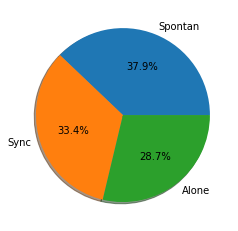

In [44]:
sizes = final["Label"].value_counts()
labels = 'Spontan', 'Sync', 'Alone'
plt.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True);

we can see that our data is not balanced, and that the biggest portion is of the spontanious rows

Next lets see how diverse is the movement of each hand, according to hand, wrist and elbow positioning

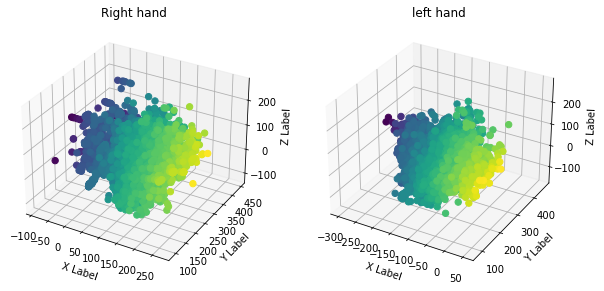

In [45]:
xr = final[' Position X_R']
yr= final[' Position Y_R']
zr = final[' Position Z_R']


# first plots for hand positioning
fig = plt.figure(figsize=(10,5))

ax_R =  fig.add_subplot(1, 2, 1, projection='3d')
sc = ax_R.scatter(xr, yr, zr, s=40, c=xr, marker='o', alpha=1)

ax_R.set_xlabel('X Label')
ax_R.set_ylabel('Y Label')
ax_R.set_zlabel('Z Label')
ax_R.set_title("Right hand")

xl = final[' Position X_L']
yl= final[' Position Y_L']
zl = final[' Position Z_L']

ax_L =  fig.add_subplot(1, 2, 2, projection='3d')
sc = ax_L.scatter(xl, yl, zl, s=40, c=xl, marker='o', alpha=1)
ax_L.set_xlabel('X Label')
ax_L.set_ylabel('Y Label')
ax_L.set_zlabel('Z Label')
ax_L.set_title("left hand")

plt.show()

We can see that we have on outlier, and since it can throw our model off, lets remove him

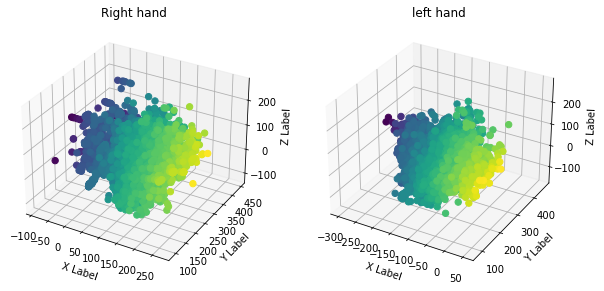

In [46]:
xr = final[' Position X_R']
yr= final[' Position Y_R']
zr = final[' Position Z_R']


# subplot after dropping the outlier
fig = plt.figure(figsize=(10,5))

ax_R =  fig.add_subplot(1, 2, 1, projection='3d')
sc = ax_R.scatter(xr, yr, zr, s=40, c=xr, marker='o', alpha=1)

ax_R.set_xlabel('X Label')
ax_R.set_ylabel('Y Label')
ax_R.set_zlabel('Z Label')
ax_R.set_title("Right hand")

xl = final[' Position X_L']
yl= final[' Position Y_L']
zl = final[' Position Z_L']

ax_L =  fig.add_subplot(1, 2, 2, projection='3d')
sc = ax_L.scatter(xl, yl, zl, s=40, c=xl, marker='o', alpha=1)
ax_L.set_xlabel('X Label')
ax_L.set_ylabel('Y Label')
ax_L.set_zlabel('Z Label')
ax_L.set_title("left hand")

plt.show()

Now all of our values on the x axis are between 200 and -200 for the right hand, and for the left hand between 0 and -300

Next i will also plot the elbow and wrist position of both hands

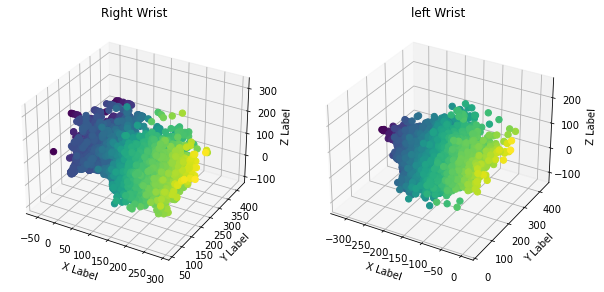

In [47]:
wrist_x_r = final[' Wrist Pos X_R']
wrist_y_r= final[' Wrist Pos Y_R']
wrist_z_r = final[' Wrist Pos Z_R']

wrist_x_l = final[' Wrist Pos X_L']
wrist_y_l= final[' Wrist Pos Y_L']
wrist_z_l = final[' Wrist Pos Z_L']


fig = plt.figure(figsize=(10,5))

ax_R =  fig.add_subplot(1, 2, 1, projection='3d')
sc = ax_R.scatter(wrist_x_r, wrist_y_r, wrist_z_r, s=40, c=wrist_x_r, marker='o', alpha=1)
ax_R.set_xlabel('X Label')
ax_R.set_ylabel('Y Label')
ax_R.set_zlabel('Z Label')
ax_R.set_title("Right Wrist")

ax_L =  fig.add_subplot(1, 2, 2, projection='3d')
sc = ax_L.scatter(wrist_x_l, wrist_y_l, wrist_z_l, s=40, c=wrist_x_l, marker='o', alpha=1)
ax_L.set_xlabel('X Label')
ax_L.set_ylabel('Y Label')
ax_L.set_zlabel('Z Label')
ax_L.set_title("left Wrist")
plt.show()

From what we can see, the person with right hand had a bigger range of motion then the person on the left, and the person on the left was more stable and kept moving in the same area

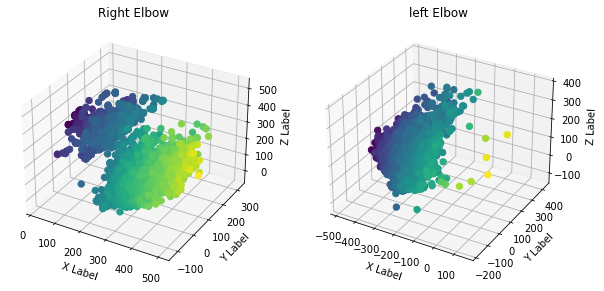

In [48]:
elbow_x_r = final[' Elbow pos X_R']
elbow_y_r= final[' Elbow Pos Y_R']
elbow_z_r = final[' Elbow Pos Z_R']

elbow_x_l = final[' Elbow pos X_L']
elbow_y_l= final[' Elbow Pos Y_L']
elbow_z_l = final[' Elbow Pos Z_L']


fig = plt.figure(figsize=(10,5))

ax_R =  fig.add_subplot(1, 2, 1, projection='3d')
sc = ax_R.scatter(elbow_x_r, elbow_y_r, elbow_z_r, s=40, c=elbow_x_r, marker='o', alpha=1)
ax_R.set_xlabel('X Label')
ax_R.set_ylabel('Y Label')
ax_R.set_zlabel('Z Label')
ax_R.set_title("Right Elbow")

ax_L =  fig.add_subplot(1, 2, 2, projection='3d')
sc = ax_L.scatter(elbow_x_l, elbow_y_l, elbow_z_l, s=40, c=elbow_x_l, marker='o', alpha=1)
ax_L.set_xlabel('X Label')
ax_L.set_ylabel('Y Label')
ax_L.set_zlabel('Z Label')
ax_L.set_title("left Elbow")
plt.show()

We can see that there are some outlier in the left elbow position, lets try to locate and remove them

we will do the same for the right hand

In [49]:
outlier = final.loc[final[' Elbow pos X_L']  > -100]
outlier.head()

,Time_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,Pitch_R,Roll_R,Yaw_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
2156,191.8333,11.88127,272.5593,42.841790,514.4213,586.89950,17.17734,0.706017,-0.286141,0.151125,...,-0.936928,235.52300,73.690310,-60.16991,172.73460,239.92110,1.0,3.141593,1.000000,0
2889,520.3361,119.69150,182.1022,-4.530864,-29.3058,46.40965,-78.25695,0.614111,-0.333246,-0.637674,...,-137.820300,83.69337,3.461484,-93.51716,-118.08430,125.87270,0.0,0.128481,0.000000,2
3851,220.4206,121.40400,157.3092,41.921030,428.0236,202.65590,164.17540,1.224425,-0.144959,-0.085554,...,-142.283100,142.34180,15.775600,-75.32963,-35.47841,81.95055,1.0,3.141593,1.000000,1
3868,226.0536,166.32680,241.0991,-23.470090,119.5682,126.43470,80.65329,1.315301,-0.562733,-1.311412,...,-180.027700,133.52590,38.331120,-89.50343,-77.10136,119.72330,1.0,2.566171,1.000000,1
3869,226.3848,169.54610,241.1318,-23.113230,114.9667,65.43668,32.27048,1.284721,-0.672023,-0.976178,...,-145.563900,35.57426,27.263750,63.92377,-121.91720,129.29610,0.0,0.654854,0.084723,1


In [50]:
final.shape

(4566, 39)

In [51]:
final = final.loc[final[' Elbow pos X_L'] < -100]
final.shape

(4551, 39)

In [52]:
outlier = final.loc[final[' Elbow pos X_R']  > 500]
outlier

,Time_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,Pitch_R,Roll_R,Yaw_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
544,475.196,231.9504,248.0817,82.87532,294.6602,401.3189,104.392,2.567719,-0.108701,-1.754265,...,-181.9251,150.5285,50.88777,-272.9208,-5.636758,-3.409652,0.655198,1.63706,1.0,2


In [53]:
final = final.loc[final[' Elbow pos X_R']  < 500]
final.shape

(4550, 39)

In [54]:
outlier = final.loc[final[' Elbow Pos Y_R']  > 400]
outlier

,Time_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,Pitch_R,Roll_R,Yaw_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label


In [55]:
final = final.loc[final[' Elbow Pos Y_R']  < 400]
final.shape

(4550, 39)

In [56]:
outlier = final.loc[final[' Elbow Pos Y_L']  > 400]
outlier

,Time_R,Position X_R,Position Y_R,Position Z_R,Velocity X_R,Velocity Y_R,Velocity Z_R,Pitch_R,Roll_R,Yaw_R,...,Wrist Pos X_L,Wrist Pos Y_L,Wrist Pos Z_L,Elbow pos X_L,Elbow Pos Y_L,Elbow Pos Z_L,Grab Strenth_L,Grab Angle_L,Pinch Strength_L,Label
4421,148.8311,51.75742,329.2992,59.32721,88.45947,410.994,80.31835,0.481149,0.149039,-0.035795,...,-131.0488,333.9253,23.58307,-319.7856,420.1246,167.9243,0.0,0.683031,0.305249,0


In [57]:
final = final.loc[final[' Elbow Pos Y_L']  < 400]
final.shape

(4549, 39)

lets see how the data looks now

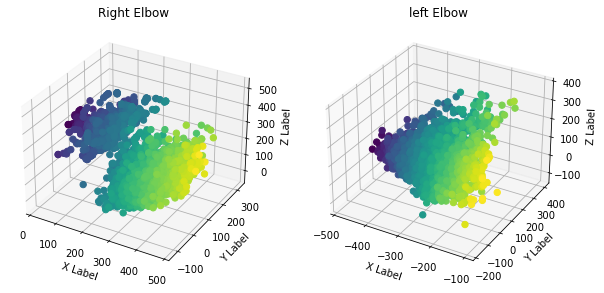

In [58]:
elbow_x_r = final[' Elbow pos X_R']
elbow_y_r= final[' Elbow Pos Y_R']
elbow_z_r = final[' Elbow Pos Z_R']

elbow_x_l = final[' Elbow pos X_L']
elbow_y_l= final[' Elbow Pos Y_L']
elbow_z_l = final[' Elbow Pos Z_L']


fig = plt.figure(figsize=(10,5))

ax_R =  fig.add_subplot(1, 2, 1, projection='3d')
sc = ax_R.scatter(elbow_x_r, elbow_y_r, elbow_z_r, s=40, c=elbow_x_r, marker='o', alpha=1)
ax_R.set_xlabel('X Label')
ax_R.set_ylabel('Y Label')
ax_R.set_zlabel('Z Label')
ax_R.set_title("Right Elbow")

ax_L =  fig.add_subplot(1, 2, 2, projection='3d')
sc = ax_L.scatter(elbow_x_l, elbow_y_l, elbow_z_l, s=40, c=elbow_x_l, marker='o', alpha=1)
ax_L.set_xlabel('X Label')
ax_L.set_ylabel('Y Label')
ax_L.set_zlabel('Z Label')
ax_L.set_title("left Elbow")
plt.show()

Next lets prep the test data so we can start working on models

# Prepering to start the training process

In [59]:
train_labels = final.Label.values
train_data = final.drop(['Label'],axis = 1).values

In [60]:
test_labels = test_final.Label.values
test_data = test_final.drop(['Label'],axis = 1).values

In [61]:
validation_labels = my_test_final.Label.values
validation_data = my_test_final.drop(['Label'],axis = 1).values

# Scaling the data

Next Lets scale the data beacuse we have values in hunderds and also values between 0 and 1

In [62]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
validation_data = scaler.transform(validation_data)

# Training week learners

First i will try to see what time it takas and how much accuracy we get for certein models before PCA

In [118]:
model_names = []
time_before_pca = []
time_after_pca = [] 
score_before_pca = []
score_after_pca = []

lets try to see what is our optimal knn neighbors amount

In [119]:
knn = KNeighborsClassifier()
n_range = np.arange(50,251,50)
knn_scores = []
for n in n_range:
    knn.n_neighbors = n
    knn.fit(train_data,train_labels)
    pred = knn.predict(validation_data)
    knn_scores.append(metrics.accuracy_score(validation_labels, pred))

<AxesSubplot:>

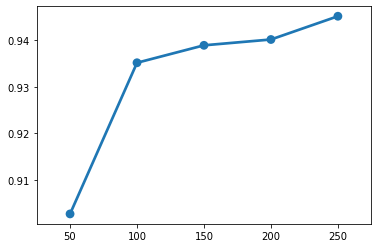

In [120]:
sns.pointplot(x = n_range, y = knn_scores)

For knn we will use 250 neighbors, now lets set the other week learners to use with voting

In [121]:
gnb = GaussianNB()
LoR = LogisticRegression(random_state = 10)
knn_before = KNeighborsClassifier(n_neighbors= 250)
DT = DecisionTreeClassifier(max_depth = 5)
soft_voting = VotingClassifier(estimators = [('knn_before',knn_before),('lr',LoR),('decision_tree',DT),('gaussian_bayes',gnb)],n_jobs = -1,voting='soft')
hard_voting = VotingClassifier(estimators = [('knn_before',knn_before),('lr',LoR),('decision_tree',DT),('gaussian_bayes',gnb)],n_jobs = -1,voting='hard')

In [122]:
for clf in (gnb,LoR,knn_before,DT,soft_voting,hard_voting):
    start_time = time.time()
    clf.fit(train_data, train_labels)
    time_to_train = time.time() - start_time
    pred = clf.predict(validation_data)
    score = metrics.accuracy_score(validation_labels,pred)
    name = clf.__class__.__name__
    time_before_pca.append(time_to_train)
    score_before_pca.append(score)
    model_names.append(name)
    print(name + " score is: %.3f" %(score) + " and it took %.2f second to train" %(time_to_train))

GaussianNB score is: 0.837 and it took 0.01 second to train
LogisticRegression score is: 0.991 and it took 0.21 second to train
KNeighborsClassifier score is: 0.945 and it took 0.06 second to train
DecisionTreeClassifier score is: 0.911 and it took 0.07 second to train
VotingClassifier score is: 0.975 and it took 0.32 second to train
VotingClassifier score is: 0.983 and it took 0.31 second to train


This time lets use bagging on the desicion tree classifier, also known as random forest classifier

In [123]:
RF = RandomForestClassifier(max_depth = 5)
n_range = np.arange(100,1001,100)
RF_score = []
for n in n_range:
    RF.n_estimators = n
    RF.fit(train_data,train_labels)
    pred = RF.predict(validation_data)
    RF_score.append(metrics.accuracy_score(validation_labels, pred))

<AxesSubplot:>

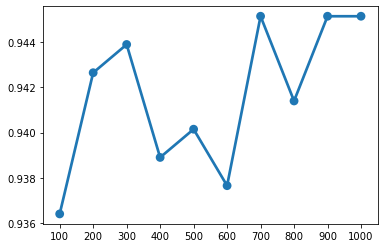

In [124]:
sns.pointplot(x = n_range, y = RF_score)

Lets use 500 trees for our RF classifier

RandomForestClassifier score is 0.939 and it took 4.89 seconds to calculate


<AxesSubplot:>

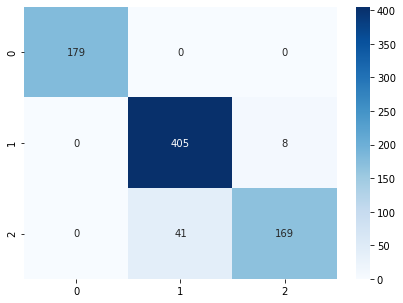

In [125]:
start_time = time.time()
RF_before = RandomForestClassifier(n_estimators = 500, max_depth = 5)
RF_before.fit(train_data, train_labels)
time_to_train = time.time() - start_time
pred =RF_before.predict(validation_data)
score = metrics.accuracy_score(validation_labels,pred)
name = RF_before.__class__.__name__
time_before_pca.append(time_to_train)
score_before_pca.append(score)
model_names.append(name)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Blues")

Lets move onto Boosting with adaBoost

AdaBoostClassifier score is 0.869 and it took 16.73 seconds to calculate


<AxesSubplot:>

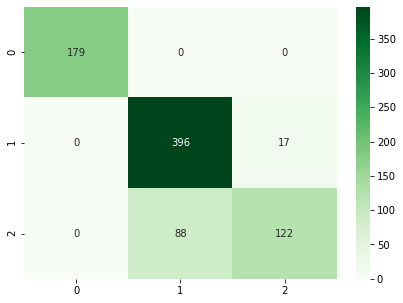

In [126]:
start_time = time.time()
adaBoost_before = AdaBoostClassifier(base_estimator= DT, n_estimators=200, learning_rate= 0.75)
adaBoost_before.fit(train_data, train_labels)
time_to_train = time.time() - start_time
pred =adaBoost_before.predict(validation_data)
score = metrics.accuracy_score(validation_labels,pred)
name = adaBoost_before.__class__.__name__
time_before_pca.append(time_to_train)
score_before_pca.append(score)
model_names.append(name)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Greens")

Next, lets try Gradient Boosting

GradientBoostingClassifier score is 0.798 and it took 75.56 seconds to calculate


<AxesSubplot:>

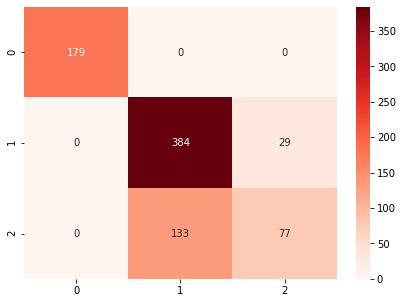

In [127]:
start_time = time.time()
gBoost_before = GradientBoostingClassifier(n_estimators=500, learning_rate= 0.25)
gBoost_before.fit(train_data, train_labels)
time_to_train = time.time() - start_time
pred =gBoost_before.predict(validation_data)
score = metrics.accuracy_score(validation_labels,pred)
name = gBoost_before.__class__.__name__
time_before_pca.append(time_to_train)
score_before_pca.append(score)
model_names.append(name)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Reds")

As we can see,the biggest difficulty is identifying between sync and spontan rows.

gredient boosting doesnt give us the best result, lets try to get a better result with xgboost

XGBClassifier score is 0.814 and it took 1.09 seconds to calculate


<AxesSubplot:>

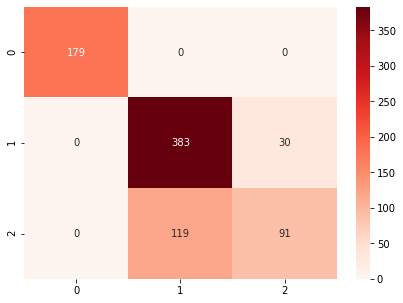

In [128]:
start_time = time.time()
xgBoost_before = xgboost.XGBClassifier(n_estimators=250, learning_rate=0.75,eval_metric = "merror")
xgBoost_before.fit(train_data, train_labels)
time_to_train = time.time() - start_time
pred =xgBoost_before.predict(validation_data)
score = metrics.accuracy_score(validation_labels,pred)
name = xgBoost_before.__class__.__name__
time_before_pca.append(time_to_train)
score_before_pca.append(score)
model_names.append(name)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Reds")

StackingClassifier score is 0.956 and it took 114.79 seconds to calculate


<AxesSubplot:>

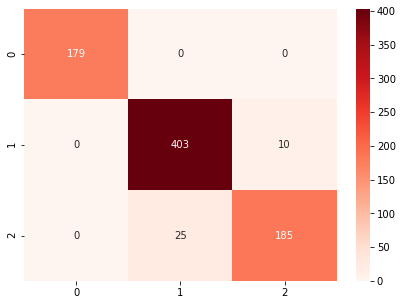

In [129]:
start_time = time.time()
estimators = [("logistic regression",LoR),("Random forest",RF_before),("adaBoost",adaBoost_before),("knn",knn_before)]
stack_before = StackingClassifier(estimators = estimators, final_estimator=hard_voting )
stack_before.fit(train_data,train_labels)
time_to_train = time.time() - start_time
pred = stack_before.predict(validation_data)
score = metrics.accuracy_score(validation_labels,pred)
name = stack_before.__class__.__name__
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Reds")

After running all the models, lets try to reduce our dimensions using PCA and then try to see what accuracy we get

In [130]:
pca = PCA()
pca.fit(train_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)

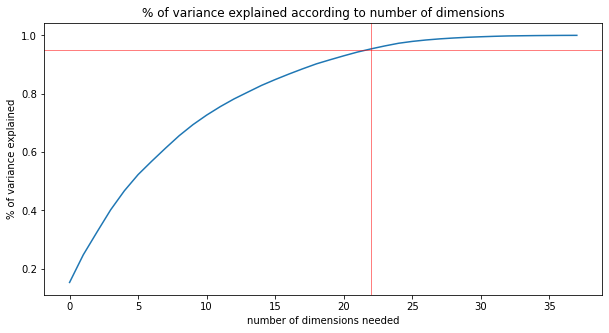

In [131]:
plt.figure(figsize = [10,5])
plt.plot(cumsum)
plt.ylabel("% of variance explained")
plt.xlabel("number of dimensions needed")
plt.title("% of variance explained according to number of dimensions");
plt.axhline(y=0.95, linewidth=0.5, color='r');
plt.axvline(x=22, linewidth=0.5, color='r');

as we can see we need 22 dimensions to explain 95% of the variance, so that is that amount of dimensions we will use

In [132]:
pca = PCA(n_components = 22)
data_reduced = pca.fit_transform(train_data)
test_reduced = pca.transform(test_data)
validation_reduced = pca.transform(validation_data)

In [133]:
data_reduced.shape

(4549, 22)

Lets train our models again, this time on the reduced data

In [134]:
knn = KNeighborsClassifier()
n_range = np.arange(50,251,50)
knn_scores = []
for n in n_range:
    knn.n_neighbors = n
    knn.fit(data_reduced,train_labels)
    pred = knn.predict(validation_reduced)
    knn_scores.append(metrics.accuracy_score(validation_labels, pred))

<AxesSubplot:>

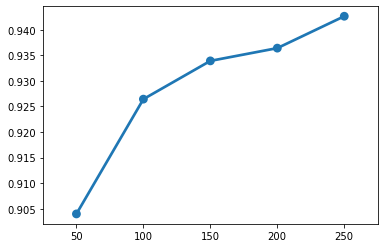

In [135]:
sns.pointplot(x = n_range, y = knn_scores)

Again we will use 250 neighbors

In [218]:
gnb = GaussianNB()
LoR = LogisticRegression(random_state = 10)
knn_after = KNeighborsClassifier(n_neighbors= 250)
DT = DecisionTreeClassifier(max_depth = 5)
soft_voting = VotingClassifier(estimators = [('knn_before',knn_after),('lr',LoR),('decision_tree',DT),('gaussian_bayes',gnb)],n_jobs = -1,voting='soft')
hard_voting = VotingClassifier(estimators = [('knn_before',knn_after),('lr',LoR),('decision_tree',DT),('gaussian_bayes',gnb)],n_jobs = -1,voting='hard')

In [219]:
for clf in (gnb,LoR,knn_after,DT,soft_voting,hard_voting):
    start_time = time.time()
    clf.fit(data_reduced, train_labels)
    time_to_train = time.time() - start_time
    pred = clf.predict(validation_reduced)
    score = metrics.accuracy_score(validation_labels,pred)
    name = clf.__class__.__name__
    #time_after_pca.append(time_to_train)
    #score_after_pca.append(score)
    print(name + " score is: %.3f" %(score) + " and it took %.2f second to train" %(time_to_train))

GaussianNB score is: 0.950 and it took 0.00 second to train
LogisticRegression score is: 0.983 and it took 0.17 second to train
KNeighborsClassifier score is: 0.943 and it took 0.03 second to train
DecisionTreeClassifier score is: 0.815 and it took 0.06 second to train
VotingClassifier score is: 0.956 and it took 2.13 second to train
VotingClassifier score is: 0.968 and it took 1.42 second to train


Lets use random forest classifer on our reduced data

In [148]:
n_range = np.arange(100,501,100)
bag_scores = []
RF = RandomForestClassifier(max_depth = 5)
for n in n_range:
    RF.n_estimators = n
    RF.fit(data_reduced,train_labels)
    pred = RF.predict(validation_reduced)
    bag_scores.append(metrics.accuracy_score(validation_labels,pred))

<AxesSubplot:>

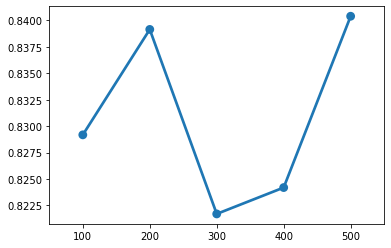

In [149]:
sns.pointplot(x = n_range, y = bag_scores)

lets use 500 estimators for the best accuracy

RandomForestClassifier score is: 0.840 and it took 4.18 second to train


<AxesSubplot:>

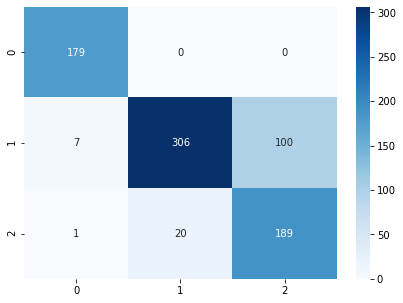

In [185]:
start_time = time.time()
RF_after = RandomForestClassifier(n_estimators=500,max_depth = 5)
RF_after.fit(data_reduced,train_labels)
time_to_train = time.time() - start_time
pred = RF_after.predict(validation_reduced)
score = metrics.accuracy_score(validation_labels,pred)
name = RF_after.__class__.__name__
#score_after_pca.append(score)
#time_after_pca.append(time_to_train)
print(name + " score is: %.3f" %(score) + " and it took %.2f second to train" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Blues")

lets move on to Boosting now

AdaBoostClassifier score is 0.879 and it took 11.52 seconds to calculate


<AxesSubplot:>

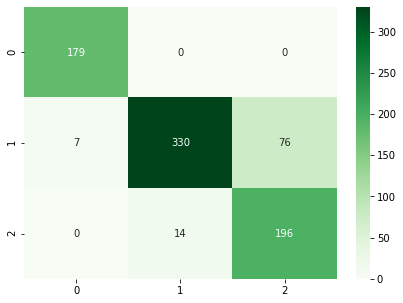

In [161]:
start_time = time.time()
adaBoost_after = AdaBoostClassifier(base_estimator= DT, n_estimators=200, learning_rate= 0.75)
adaBoost_after.fit(data_reduced, train_labels)
time_to_train = time.time() - start_time
pred =adaBoost_after.predict(validation_reduced)
score = metrics.accuracy_score(validation_labels,pred)
name = adaBoost_after.__class__.__name__
time_after_pca.append(time_to_train)
score_after_pca.append(score)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Greens")

GradientBoostingClassifier score is 0.928 and it took 15.34 seconds to calculate


<AxesSubplot:>

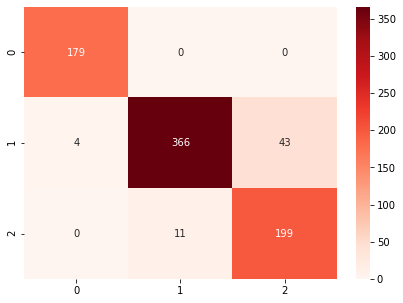

In [172]:
start_time = time.time()
gBoost_after = GradientBoostingClassifier(n_estimators=150, learning_rate= 0.75)
gBoost_after.fit(data_reduced, train_labels)
time_to_train = time.time() - start_time
pred =gBoost_after.predict(validation_reduced)
score = metrics.accuracy_score(validation_labels,pred)
name = gBoost_after.__class__.__name__
time_after_pca.append(time_to_train)
score_after_pca.append(score)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="Reds")

as we can see, after PCA, we got a much better result on our gradient boosting classifier!

XGBClassifier score is 0.914 and it took 2.71 seconds to calculate


<AxesSubplot:>

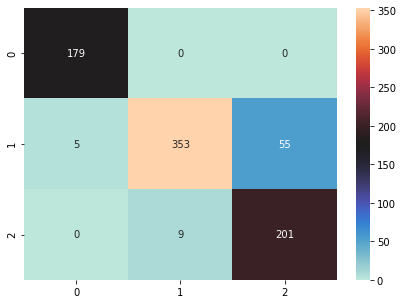

In [199]:
start_time = time.time()
xgBoost_after = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.5,eval_metric = "merror")
xgBoost_after.fit(data_reduced, train_labels)
time_to_train = time.time() - start_time
pred =xgBoost_after.predict(validation_reduced)
score = metrics.accuracy_score(validation_labels,pred)
name = xgBoost_after.__class__.__name__
time_after_pca.append(time_to_train)
score_after_pca.append(score)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="icefire")

With XGBoost we also got a better score then before! by around 10%, our last classifier will be stacking

StackingClassifier score is 0.968 and it took 98.63 seconds to calculate


<AxesSubplot:>

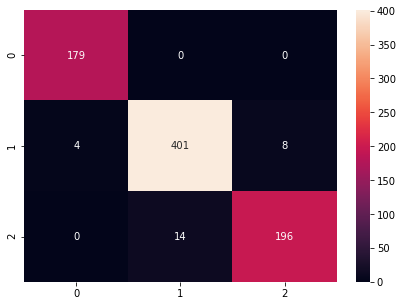

In [212]:
start_time = time.time()
estimators = [("logistic regression",LoR),("Random forest",RF_after),("adaBoost",gBoost_after),("knn",knn_after)]
stack_after = StackingClassifier(estimators = estimators, final_estimator = hard_voting )
stack_after.fit(data_reduced,train_labels)
time_to_train = time.time() - start_time
pred = stack_after.predict(validation_reduced)
score = metrics.accuracy_score(validation_labels,pred)
name = stack_after.__class__.__name__
#score_after_pca.append(score)
#time_after_pca.append(time_to_train)
print(name + " score is %.3f" %(score) + " and it took %.2f seconds to calculate" %(time_to_train))
con_mat = metrics.confusion_matrix(validation_labels, pred)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="rocket")

Next lets plot and see what the best classifiert was according to the time it took to train him, and also before nad after PCA

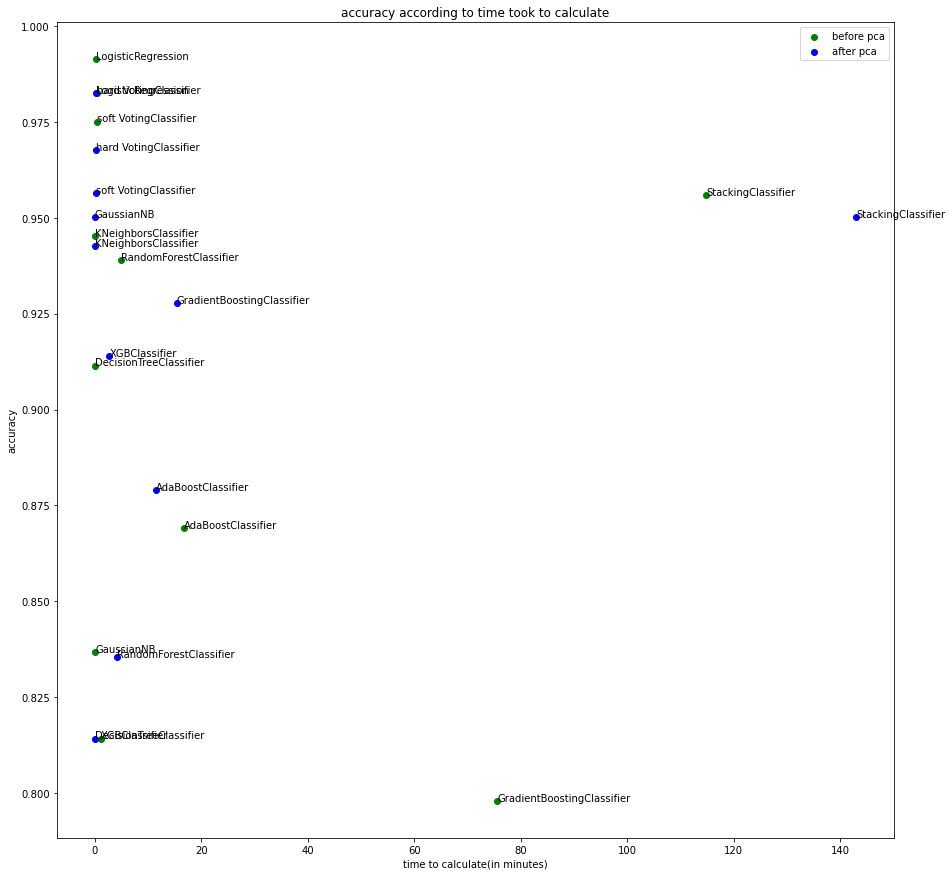

In [210]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(time_before_pca,score_before_pca, c='green', label = "before pca")
for i, txt in enumerate(model_names):
    ax.annotate(txt, (time_before_pca[i], score_before_pca[i]))
    
ax.scatter(time_after_pca, score_after_pca,c='blue', label = "after pca")

for i, txt in enumerate(model_names):
    ax.annotate(txt, (time_after_pca[i], score_after_pca[i]))
    
plt.ylabel("accuracy")
plt.xlabel("time to calculate(in minutes)")
plt.title("accuracy according to time took to calculate");
plt.legend()

In [228]:
pred_val =RF_after.predict(validation_reduced)
pred_test = RF_after.predict(test_reduced)
print(metrics.accuracy_score(validation_labels,pred_val))
print(metrics.accuracy_score(test_labels,pred_test))


0.8403990024937655
0.7795371498172959


# Conclusion  <a id='conclusion'></a>

After trying all the models that I have trained, the one with the best accuracy when predicting the test set was the Random forest clssifier after using PCA and training it on the reduced data.

In this notebook, there was a lot of preproccesing work to do, compared to the other notebooks in this project. First I needed to know how to import all the diffrent files and how to merge the right and left rows,how to merge all the files themselves, and also to categorize them correctly. This was done 3 times, for the train, validation and final test data

After this i visualized some of the data, and then started training models, Reduced the amount of dimensions by almost half (from 39 to 22) using PCA, the trained the same models on the reduced Data